In [629]:
import os
import re
import sys
import glob
import numpy  as np
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt

from invisible_cities.database  import load_db
from invisible_cities.io.dst_io import load_dst
from invisible_cities.io.dst_io import df_writer

In [630]:
# Rewrite to get values from the file
def get_x_y_z(filename):
   parts = pd.read_hdf(filename, 'MC/particles')

   parts[['event_id', 'particle_id', 'particle_name', 'primary', 'initial_x', 'initial_y', 'initial_z']].head(10)

get_x = lambda filename: get_x_y_z(filename)[0]
get_z = lambda filename: get_x_y_z(filename)[2]

In [631]:
# Load in the files
lt_dir = os.path.expandvars("../files/S1/")
# lt_dir = os.path.expandvars("../config/")
lt_filenames = glob.glob(os.path.join(lt_dir, "*.h5"))
lt_filenames = sorted(lt_filenames)
print(lt_filenames)

# Configure the detector database
detector_db = "new"
datapmt = load_db.DataPMT(detector_db, 0)
xpmt, ypmt = datapmt["X"].values, datapmt["Y"].values
sensorids  = datapmt["SensorID"].values

['../files/S1/NEW_S1_LT_11.next.h5', '../files/S1/NEW_S1_LT_12.next.h5', '../files/S1/NEW_S1_LT_20.next.h5', '../files/S1/NEW_S1_LT_24.next.h5', '../files/S1/NEW_S1_LT_30.next.h5', '../files/S1/NEW_S1_LT_39.next.h5', '../files/S1/NEW_S1_LT_40.next.h5', '../files/S1/NEW_S1_LT_8.next.h5', '../files/S1/NEW_S1_LT_9.next.h5']


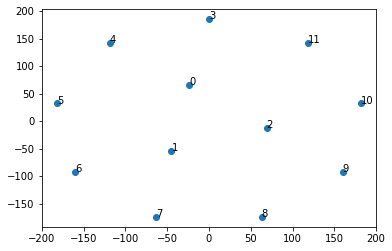

In [632]:
plt.scatter(xpmt, ypmt)
for x, y, sid  in zip(xpmt, ypmt, sensorids):
    plt.annotate(sid, (x, y))

In [633]:
filename = lt_filenames[0]
print(filename)
parts = pd.read_hdf(filename, 'MC/particles')
parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]


../files/S1/NEW_S1_LT_11.next.h5


In [634]:
# Get the metadata from the files
configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
num_events = int(configuration.loc["num_events"][0])
nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

sns_response  = pd.read_hdf(filename, "MC/sns_response")
pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]

pd.set_option('display.max_rows', None)
display(pmt_response.head(10))

,event_id,sensor_id,time_bin,charge
282,1100,8,0,1072
283,1100,6,0,1130
284,1100,6,1,1
285,1100,11,0,932
286,1100,11,1,1
287,1100,3,0,945
288,1100,4,0,1003
289,1100,4,1,1
290,1100,7,0,1063
291,1100,1,0,1654


In [635]:
# protection time bins
pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()
display(pmt_response.head(11))

,sensor_id,event_id,charge
0,0,1100,1451
1,0,1101,1199
2,0,1102,669
3,0,1103,1073
4,0,1104,1803
5,0,1105,1138
6,0,1106,697
7,0,1107,894
8,0,1108,818
9,0,1109,1413


In [636]:
# Merge the dataframes to add the x, y, z positions
pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')
display(pmt_response.head(10))

,sensor_id,event_id,charge,initial_x,initial_y,initial_z
0,0,1100,1451,-49.834881,-61.838348,416.637848
1,1,1100,1656,-49.834881,-61.838348,416.637848
2,2,1100,1402,-49.834881,-61.838348,416.637848
3,3,1100,945,-49.834881,-61.838348,416.637848
4,4,1100,1004,-49.834881,-61.838348,416.637848
5,5,1100,1086,-49.834881,-61.838348,416.637848
6,6,1100,1131,-49.834881,-61.838348,416.637848
7,7,1100,1063,-49.834881,-61.838348,416.637848
8,8,1100,1072,-49.834881,-61.838348,416.637848
9,9,1100,1005,-49.834881,-61.838348,416.637848


In [637]:
# Normalise the charge in each PMT by the total number of photons simulated
pmt_response['charge'] = pmt_response['charge']/nphotons

LT = pmt_response

display(LT.head(11))

,sensor_id,event_id,charge,initial_x,initial_y,initial_z
0,0,1100,0.001451,-49.834881,-61.838348,416.637848
1,1,1100,0.001656,-49.834881,-61.838348,416.637848
2,2,1100,0.001402,-49.834881,-61.838348,416.637848
3,3,1100,0.000945,-49.834881,-61.838348,416.637848
4,4,1100,0.001004,-49.834881,-61.838348,416.637848
5,5,1100,0.001086,-49.834881,-61.838348,416.637848
6,6,1100,0.001131,-49.834881,-61.838348,416.637848
7,7,1100,0.001063,-49.834881,-61.838348,416.637848
8,8,1100,0.001072,-49.834881,-61.838348,416.637848
9,9,1100,0.001005,-49.834881,-61.838348,416.637848


In [638]:
# # to df
# LT = LT.to_frame().reset_index()
# LT["x"] = x; 
# LT["y"] = y; 
# LT["z"] = z;
# err = err.to_frame().reset_index()
# err["x"] = x; 
# err["y"] = y; 
# err["z"] = z;

# LT  = pd.pivot_table(LT , values="charge", columns="sensor_id", index=["x", "y", "z"])
# err = pd.pivot_table(err, values="charge", columns="sensor_id", index=["x", "y", "z"])
# LT .columns = LT .columns.rename("")
# err.columns = err.columns.rename("")


In [639]:
# display(LT.head(11))
# LT.info()

In [640]:
LT  = pd.DataFrame()
ERR = pd.DataFrame()

for i, filename in enumerate(lt_filenames, 1):
    sys.stdout.write(f"Processing file {i}/{len(lt_filenames)} \r")
    sys.stdout.flush()
    
    # x, y, z = get_x_y_z(filename)
    
    configuration = pd.read_hdf(filename, "MC/configuration").set_index("param_key")
    num_events = int(configuration.loc["num_events"][0])
    nphotons   = int(configuration.loc["/Generator/ScintGenerator/nphotons"][0])

    sns_response  = pd.read_hdf(filename, "MC/sns_response")
    pmt_response  = sns_response[np.isin(sns_response["sensor_id"].values, datapmt["SensorID"].values)]
    
    # protection time bins
    pmt_response = pmt_response.groupby(["sensor_id", "event_id"])["charge"].sum().to_frame().reset_index()

    # Load in the MC Particles
    parts = pd.read_hdf(filename, 'MC/particles')
    parts = parts[['event_id', 'initial_x', 'initial_y', 'initial_z']]

    # Merge the dataframes
    pmt_response = pmt_response.merge(parts, on="event_id", how = 'inner')

    # Now bin the x, y, z positions
    pmt_response['x'] = pd.cut(x=pmt_response['initial_x'], bins=xbins,labels=xbins_centre, include_lowest=True)
    pmt_response['y'] = pd.cut(x=pmt_response['initial_y'], bins=ybins,labels=ybins_centre, include_lowest=True)
    pmt_response['z'] = pd.cut(x=pmt_response['initial_z'], bins=zbins,labels=zbins_centre, include_lowest=True)

    # remove the initial x,y,z since we are done with them
    pmt_response = pmt_response.drop(columns=['initial_x', 'initial_y', 'initial_z'])

    # Normalise the charge in each PMT by the total number of photons simulated
    pmt_response['charge'] = pmt_response['charge']/nphotons
    
    # mean = pmt_response.groupby("sensor_id")["charge"].mean()
    # std  = pmt_response.groupby("sensor_id")["charge"].std()

    # lt  = mean/nphotons 
    # err = std/mean*100
    
    # to df
    # lt = lt.to_frame().reset_index()
    # lt["x"] = x; lt["y"] = y; lt["z"] = z;
    # err = err.to_frame().reset_index()
    # err["x"] = x; err["y"] = y; err["z"] = z;

    # lt  = pd.pivot_table(lt , values="charge", columns="sensor_id", index=["x", "y", "z"])
    # err = pd.pivot_table(err, values="charge", columns="sensor_id", index=["x", "y", "z"])
    
    LT  = pd.concat([LT , pmt_response])
    # ERR = pd.concat([ERR, err])



In [641]:
lt = LT.groupby(["sensor_id", "x", "y", "z"])["charge"].sum().to_frame().reset_index()
display(lt.head(10))

,sensor_id,x,y,z,charge
0,0,-190.0,-190.0,25.0,NaN
1,0,-190.0,-190.0,75.0,NaN
2,0,-190.0,-190.0,125.0,NaN
3,0,-190.0,-190.0,175.0,NaN
4,0,-190.0,-190.0,225.0,NaN
5,0,-190.0,-190.0,275.0,NaN
6,0,-190.0,-190.0,325.0,NaN
7,0,-190.0,-190.0,375.0,NaN
8,0,-190.0,-190.0,425.0,NaN
9,0,-190.0,-190.0,475.0,NaN


In [642]:
lt.columns = lt .columns.rename("")
# ERR.columns = err.columns.rename("")

lt  = lt.reset_index()
display(lt.head(10))
err = ERR.reset_index()

,index,sensor_id,x,y,z,charge
0,0,0,-190.0,-190.0,25.0,NaN
1,1,0,-190.0,-190.0,75.0,NaN
2,2,0,-190.0,-190.0,125.0,NaN
3,3,0,-190.0,-190.0,175.0,NaN
4,4,0,-190.0,-190.0,225.0,NaN
5,5,0,-190.0,-190.0,275.0,NaN
6,6,0,-190.0,-190.0,325.0,NaN
7,7,0,-190.0,-190.0,375.0,NaN
8,8,0,-190.0,-190.0,425.0,NaN
9,9,0,-190.0,-190.0,475.0,NaN


In [643]:
pmt = "PmtR11410"
signal_type = "S1"

for sid in sensorids:
    print(sid)
    lt = lt.rename({sid: pmt + f"_{sid}"}, axis=1)
    # display(lt.tail(10))
lt[pmt + f"_total"] = lt.loc[:, lt.columns.difference(["x", "y", "z"])].sum(axis=1)

if signal_type == "S2":
    lt = lt.drop("z", axis=1)

0
1
2
3
4
5
6
7
8
9
10
11


In [644]:
save = True
outfilename = f"NEW-MC_{signal_type}_LT.h5"

if save:
    with tb.open_file(outfilename, 'w') as h5out:
        df_writer(h5out, lt, "LT", "LightTable")

In [645]:
# create config
config = { "detector"   : "new"
         , "ACTIVE_rad" : str(227)
         , "EL_GAP"     : str(6.0)
         , "table_type" : "energy"
         , "signal_type": signal_type
         , "sensor"     : pmt
         , "pitch_x"    : str(10)
         , "pitch_y"    : str(10)}

config = pd.DataFrame({"parameter": config.keys(), "value": config.values()})
if save:
    with tb.open_file(outfilename, 'r+') as h5out:
        df_writer(h5out, config, "LT", "Config")

In [646]:
lt     = load_dst(outfilename, "LT", "LightTable")
config = load_dst(outfilename, "LT", "Config")

In [647]:
display(lt.head(10))
display(config)

,index,sensor_id,x,y,z,charge,PmtR11410_total
0,0,0,-190.0,-190.0,25.0,NaN,0.0
1,1,0,-190.0,-190.0,75.0,NaN,1.0
2,2,0,-190.0,-190.0,125.0,NaN,2.0
3,3,0,-190.0,-190.0,175.0,NaN,3.0
4,4,0,-190.0,-190.0,225.0,NaN,4.0
5,5,0,-190.0,-190.0,275.0,NaN,5.0
6,6,0,-190.0,-190.0,325.0,NaN,6.0
7,7,0,-190.0,-190.0,375.0,NaN,7.0
8,8,0,-190.0,-190.0,425.0,NaN,8.0
9,9,0,-190.0,-190.0,475.0,NaN,9.0


,parameter,value
0,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
1,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
2,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
3,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
4,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
5,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
6,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"
7,"dict_keys(['detector', 'ACTIVE_r","dict_values(['new', '227', '6.0'"


In [648]:
z = 170
sel = lt.z == z

sid = 4

plt.scatter(lt[sel].x, lt[sel].y, c=lt[sel][pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

r = float(config.set_index("parameter").loc["ACTIVE_rad"])
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

KeyError: 'PmtR11410_4'

In [ ]:
sid = 3
plt.scatter(lt.x, lt.y, c=lt[pmt + f"_{sid}"])
plt.scatter(datapmt[datapmt["SensorID"]==sid].X, datapmt[datapmt["SensorID"]==sid].Y, c="r")

r = float(config.set_index("parameter").loc["ACTIVE_rad"])
theta = np.linspace(0, 2*np.pi, 100)
x=r*np.cos(theta)
y=r*np.sin(theta)
plt.plot(x, y)

In [ ]:
df_writer(h5out, conf_psf, "PSF", "Config", str_col_length = conf_psf.value.str.len().max())

In [ ]:
filename = "/mnt/lustre/scratch/home/usc/ie/gdl/NEXT100/LightTables/NEXT100_S2_LT.h5"

lt_ex  = load_dst(filename, "LT", "LightTable")
config = load_dst(filename, "LT", "Config")

In [ ]:
from invisible_cities.core.core_functions import binedges_from_bincenters
xbins = binedges_from_bincenters(np.unique(lt["x"]))
ybins = binedges_from_bincenters(np.unique(lt["y"]))

In [ ]:
sensor_id = 2

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[12, 5])
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
# light table
h, _, _ = np.histogram2d(lt["x"], lt["y"], weights=lt[sensor_id], bins=[xbins, ybins])
im0 = ax0.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
# fig.colorbar(im0, ax=ax0)

# err
h, _, _ = np.histogram2d(err["x"], err["y"], weights=err[sensor_id], bins=[xbins, ybins])
im1 = ax1.imshow(np.flip(h.T, axis=0), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]])
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
fig.colorbar(im1, ax=ax1)

In [ ]:
sensor_id = 2

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_id])
ax1.scatter(err["x"], err["y"], c=err[sensor_id])

ax0.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")
ax1.scatter(xpmt[sensor_id], ypmt[sensor_id], c="r")

In [ ]:
old_table = os.path.expandvars("$LUSTRE/NEXT100/LightTables/NEXT100_S2_LT.h5")

from invisible_cities.io.dst_io import load_dst
old = load_dst(old_table, "LT", "LightTable")

In [ ]:
sensor_id = 31

fig, (ax0, ax1) = plt.subplots(1,2, figsize=[15, 5])

ax0.set_title("new")
ax0.scatter(lt["x"], lt["y"], c=lt[sensor_id])


ax1.set_title("old")
ax1.scatter(old["x"], old["y"], c=old[f"PmtR11410_{sensor_id}"], s=3)


plt.figure()
_, bins, _ = plt.hist(old[f"PmtR11410_{sensor_id}"], bins=100 , density=True, histtype="step", linewidth=2)
_, _   , _ = plt.hist(lt[sensor_id]                , bins=bins, density=True, alpha=0.5);